<a href="https://colab.research.google.com/github/PranavAnand587/Lipschitz-Transformer/blob/main/Lipshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
"""
LipShift + EMMA – minimal, fully-Lipschitz, certifiable on CIFAR-10
No warmup, prints clean + verified acc + lc every epoch
"""
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision, torchvision.transforms as T
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader
import math, time, os

In [15]:

# 1-Lip modules
class CenterNorm(nn.Module):
    """1-Lipschitz channel centring (Qi et al.). instead of LayerNorm"""
    def __init__(self, C, eps=1e-6):
        super().__init__()
        self.scale = C / (C - 1.) if C > 1 else 1.
        self.weight = nn.Parameter(torch.ones(C))
        self.bias   = nn.Parameter(torch.zeros(C))
    def forward(self, x):                       # (B,N,C)
        mean = x.mean(-1, keepdim=True)
        x = self.scale * (x - mean)
        return self.weight * x + self.bias


class ChannelShift(nn.Module):
    def __init__(self, ratio=0.25):
        super().__init__()
        self.ratio = ratio
    def forward(self, x):                       # (B,N,C)
        shift = int(x.shape[-1] * self.ratio)
        return torch.cat([x[..., -shift:], x[..., :-shift]], -1)


class MinMax(nn.Module):           # 1-Lip activation
    def forward(self, x):
        return x.clamp(-1, 1)


class LipShiftBlock(nn.Module):
    def __init__(self, dim, drop=0.0):
        super().__init__()
        self.norm  = CenterNorm(dim)
        self.shift = ChannelShift()
        self.fc1   = spectral_norm(nn.Linear(dim, dim))
        self.act   = MinMax()
        self.fc2   = spectral_norm(nn.Linear(dim, dim))
        self.drop  = nn.Dropout(drop)
        self.alpha = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        res = x
        x = self.norm(x)
        x = self.shift(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop(x)
        return res + torch.tanh(self.alpha) * x


In [16]:


# model
class LipShiftNet(nn.Module):
    def __init__(self, img_size=32, patch=4, in_ch=3, num_cls=10,
                 dim=96, depth=4):
        super().__init__()
        self.patch = spectral_norm(
            nn.Conv2d(in_ch, dim, kernel_size=patch, stride=patch))
        num_p = (img_size // patch) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_p, dim))
        self.blocks = nn.Sequential(*[LipShiftBlock(dim) for _ in range(depth)])
        self.norm = CenterNorm(dim)
        self.head = spectral_norm(nn.Linear(dim, num_cls))
        self.depth = depth
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        x = self.patch(x)                 # (B,dim,H,W)
        x = x.flatten(2).transpose(1, 2)  # (B,N,dim)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = x.mean(1)                     # GAP
        x = self.norm(x)
        return self.head(x)

    # analytic lc used by EMMA
    def get_lc(self):
        with torch.no_grad():
            alpha_max = max(torch.tanh(b.alpha.abs()).item() for b in self.blocks)
            lc = (1 + alpha_max) ** self.depth
            # include patch-proj + head spectral norms
            for m in (self.patch, self.head):
                w = m.weight.view(m.weight.size(0), -1)
                lc *= torch.linalg.matrix_norm(w, 2).item()
        return lc

In [17]:


# EMMA loss
def emma_loss(model, x, y, lc, eps=8/255):
    logits = model(x)                                   # (B,Cls)
    B, C = logits.shape
    y_true = y.view(-1, 1)
    # margin matrix: lc * ||w_y - w_i||
    W = model.head.weight                               # (Cls, dim)
    W_y = W.gather(0, y_true.expand(-1, W.size(1)))   # (B, dim)
    diff = (W_y.unsqueeze(1) - W.unsqueeze(0))        # (B,Cls,dim)
    margin = lc * diff.norm(p=2, dim=-1)                # (B,Cls)
    # logits with margin
    logits = logits - logits.gather(1, y_true)          # centre true class
    eps_ji = -(logits / (margin * eps + 1e-8)).clamp(0.01, 1).detach()
    logits_rob = logits + eps_ji * eps * margin
    return F.cross_entropy(logits_rob, y.view(-1))


In [18]:


# train / eval
@torch.no_grad()
def evaluate(model, loader, device="cpu", eps=8/255):
    model.eval()
    lc = model.get_lc()
    clean, rob = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        clean += (out.argmax(1) == y).sum().item()
        # quick verified accuracy: predict same within eps-ball
        margin = lc * 1.0           # worst-case perturbation ≤ eps
        # simplest certified rule: margin < 1 → certifiably correct
        cert = (out.gather(1, y.view(-1,1)).squeeze() -
                out.max(1)[0] + margin * eps < 0)
        rob  += cert.sum().item()
    N = len(loader.dataset)
    return clean/N, rob/N, lc


In [ ]:
from tqdm import tqdm

def train():
    device = 'cuda'
    transform = T.Compose([T.ToTensor(),
                           T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset  = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    test_loader  = DataLoader(testset , batch_size=256, shuffle=False, num_workers=4)

    model = LipShiftNet(dim=128, depth=6).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-2)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100)

    for epoch in range(100):
        t0 = time.time()
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/100", leave=False)
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            lc = model.get_lc()
            loss = emma_loss(model, x, y, lc, eps=8/255)
            loss.backward()
            opt.step()
            loop.set_postfix(loss=loss.item(), lc=f"{lc:.2f}")

        sched.step()
        clean, ver, lc = evaluate(model, test_loader)
        print(f'epoch {epoch:02d}  clean {clean*100:5.1f}%  '
              f'verified {ver*100:5.1f}%  lc {lc:6.2f}  ({time.time()-t0:4.1f}s)')

    torch.save(model.state_dict(), 'lipshift_emma.pt')
    print('Saved lipshift_emma.pt')

if __name__ == '__main__':
    train()


epoch 00  clean  23.5%  verified  65.8%  lc   2.11  (22.6s)


epoch 01  clean  26.2%  verified  64.7%  lc   3.27  (22.5s)


epoch 02  clean  26.0%  verified  63.2%  lc   4.39  (23.2s)


epoch 03  clean  29.0%  verified  57.4%  lc   5.72  (22.4s)


epoch 04  clean  30.0%  verified  52.6%  lc   8.03  (22.6s)


epoch 05  clean  31.3%  verified  45.8%  lc  10.85  (22.3s)


epoch 06  clean  32.6%  verified  43.8%  lc  14.21  (22.3s)


epoch 07  clean  34.6%  verified  37.2%  lc  18.05  (21.2s)


epoch 08  clean  34.2%  verified  37.7%  lc  20.68  (22.2s)


epoch 09  clean  35.7%  verified  35.1%  lc  23.24  (22.5s)


epoch 10  clean  36.4%  verified  31.7%  lc  26.60  (23.3s)


epoch 11  clean  38.0%  verified  27.4%  lc  28.31  (22.4s)


epoch 12  clean  39.4%  verified  26.7%  lc  33.12  (21.8s)


epoch 13  clean  39.7%  verified  23.5%  lc  34.05  (22.4s)


epoch 14  clean  39.8%  verified  22.2%  lc  37.40  (22.6s)


epoch 15  clean  41.2%  verified  20.4%  lc  40.38  (22.6s)


epoch 16  clean  42.0%  verified  21.4%  lc  42.65  (21.7s)


epoch 17  clean  41.5%  verified  22.9%  lc  45.98  (22.4s)


epoch 18  clean  41.9%  verified  16.6%  lc  46.08  (22.9s)


epoch 19  clean  43.3%  verified  17.9%  lc  49.37  (23.6s)


epoch 20  clean  43.5%  verified  17.2%  lc  49.54  (22.5s)


epoch 21  clean  43.7%  verified  17.1%  lc  51.08  (21.8s)


epoch 22  clean  44.3%  verified  15.6%  lc  53.20  (22.8s)


epoch 23  clean  44.7%  verified  17.4%  lc  55.40  (22.7s)


epoch 24  clean  45.3%  verified  16.3%  lc  54.27  (22.8s)


epoch 25  clean  45.6%  verified  15.4%  lc  56.71  (22.7s)


epoch 26  clean  45.7%  verified  15.3%  lc  56.92  (21.9s)


epoch 27  clean  46.6%  verified  15.0%  lc  57.79  (24.1s)


epoch 28  clean  47.5%  verified  13.8%  lc  58.63  (22.7s)


epoch 29  clean  46.8%  verified  14.4%  lc  60.69  (22.6s)


epoch 30  clean  46.9%  verified  14.8%  lc  58.83  (24.1s)


epoch 31  clean  47.0%  verified  13.7%  lc  58.31  (23.7s)


epoch 32  clean  48.0%  verified  13.8%  lc  61.17  (23.3s)


epoch 33  clean  48.4%  verified  12.4%  lc  59.57  (23.6s)


epoch 34  clean  47.7%  verified  13.7%  lc  64.67  (23.7s)


epoch 35  clean  48.1%  verified  14.0%  lc  60.23  (24.3s)


epoch 36  clean  47.7%  verified  13.5%  lc  62.49  (23.0s)


epoch 37  clean  48.7%  verified  11.5%  lc  61.95  (23.1s)


epoch 38  clean  48.8%  verified  12.2%  lc  62.35  (23.5s)


epoch 39  clean  49.6%  verified  11.8%  lc  65.41  (22.3s)


epoch 40  clean  49.4%  verified  11.7%  lc  64.02  (23.0s)


epoch 41  clean  49.2%  verified  11.2%  lc  66.58  (23.3s)


epoch 42  clean  50.2%  verified  11.5%  lc  62.73  (23.2s)


epoch 43  clean  49.8%  verified  12.9%  lc  63.19  (24.0s)


epoch 44  clean  49.2%  verified  13.8%  lc  63.12  (23.1s)


epoch 45  clean  49.7%  verified  11.9%  lc  64.73  (22.4s)


epoch 46  clean  50.3%  verified  12.2%  lc  63.62  (22.9s)


epoch 47  clean  50.9%  verified  11.2%  lc  64.97  (22.7s)


epoch 48  clean  51.4%  verified  11.6%  lc  64.31  (22.5s)


epoch 49  clean  51.4%  verified  12.3%  lc  64.21  (22.4s)


epoch 50  clean  51.7%  verified  10.7%  lc  63.90  (22.4s)


epoch 51  clean  52.0%  verified  11.4%  lc  64.23  (23.7s)


epoch 52  clean  51.8%  verified  12.6%  lc  63.97  (22.7s)


epoch 53  clean  52.1%  verified  11.1%  lc  65.81  (22.4s)


epoch 54  clean  52.4%  verified  11.0%  lc  65.01  (22.6s)


epoch 55  clean  53.2%  verified  10.9%  lc  64.85  (22.3s)


epoch 56  clean  52.7%  verified  12.3%  lc  65.79  (24.1s)


epoch 57  clean  53.2%  verified  11.4%  lc  64.53  (23.0s)


epoch 58  clean  53.6%  verified  10.9%  lc  64.35  (23.1s)


epoch 59  clean  53.7%  verified  10.9%  lc  65.99  (22.6s)


epoch 60  clean  53.6%  verified  10.3%  lc  64.91  (23.4s)


epoch 61  clean  54.0%  verified  10.8%  lc  67.12  (21.4s)


epoch 62  clean  53.9%  verified  10.6%  lc  63.55  (22.3s)


epoch 63  clean  54.4%  verified  10.8%  lc  64.48  (22.4s)


epoch 64  clean  53.9%  verified  10.1%  lc  65.10  (22.9s)


epoch 65  clean  54.5%  verified  11.4%  lc  65.49  (22.6s)


epoch 66  clean  54.9%  verified  10.8%  lc  65.78  (22.4s)


epoch 67  clean  53.8%  verified  11.9%  lc  65.34  (22.8s)


epoch 68  clean  55.0%  verified  10.9%  lc  65.22  (23.7s)


epoch 69  clean  55.1%  verified  11.2%  lc  64.88  (22.3s)


epoch 70  clean  55.0%  verified  10.7%  lc  64.97  (22.0s)


epoch 71  clean  55.2%  verified  10.4%  lc  64.83  (21.4s)


epoch 72  clean  56.0%  verified  10.1%  lc  64.65  (21.9s)


epoch 73  clean  55.5%  verified  11.0%  lc  66.19  (22.3s)


epoch 74  clean  55.0%  verified  11.3%  lc  65.63  (22.0s)


epoch 75  clean  55.6%  verified  10.5%  lc  63.90  (22.0s)


epoch 76  clean  55.9%  verified  10.3%  lc  65.04  (23.4s)


epoch 77  clean  55.8%  verified  10.4%  lc  64.88  (22.8s)


epoch 78  clean  55.9%  verified  11.0%  lc  64.80  (22.3s)


epoch 79  clean  56.0%  verified  10.6%  lc  64.91  (21.7s)


epoch 80  clean  56.2%  verified  10.3%  lc  65.47  (22.2s)


epoch 81  clean  56.1%  verified  10.3%  lc  65.07  (23.6s)


epoch 82  clean  56.1%  verified  10.5%  lc  64.45  (23.8s)


epoch 83  clean  56.2%  verified  10.6%  lc  64.27  (23.7s)


epoch 84  clean  56.1%  verified  10.7%  lc  64.50  (24.4s)


epoch 85  clean  56.4%  verified  10.6%  lc  64.43  (22.9s)


epoch 86  clean  56.4%  verified  10.4%  lc  64.41  (22.3s)


epoch 87  clean  56.3%  verified  10.7%  lc  64.46  (22.4s)


epoch 88  clean  56.4%  verified  10.8%  lc  64.29  (22.5s)


epoch 89  clean  56.6%  verified  10.6%  lc  64.53  (22.4s)


epoch 90  clean  56.3%  verified  10.6%  lc  63.96  (21.7s)


epoch 91  clean  56.5%  verified  10.7%  lc  64.36  (22.6s)


epoch 92  clean  56.4%  verified  10.7%  lc  64.21  (23.6s)


epoch 93  clean  56.4%  verified  10.7%  lc  64.14  (22.6s)


epoch 94  clean  56.6%  verified  10.7%  lc  63.98  (22.6s)


epoch 95  clean  56.4%  verified  10.7%  lc  63.77  (21.9s)


epoch 96  clean  56.6%  verified  10.7%  lc  63.75  (22.6s)


epoch 97  clean  56.6%  verified  10.7%  lc  63.74  (22.5s)


epoch 98  clean  56.6%  verified  10.7%  lc  63.60  (22.5s)


epoch 99  clean  56.6%  verified  10.7%  lc  63.54  (22.0s)
Saved lipshift_emma.pt


epoch 00  loss 2.1290  clean  23.6%  verified  67.7%  lc   2.08  (174.3s)


epoch 01  loss 2.0256  clean  26.1%  verified  63.5%  lc   3.26  (173.9s)


epoch 02  loss 1.9717  clean  27.5%  verified  59.3%  lc   4.55  (173.1s)


epoch 03  loss 1.9247  clean  27.4%  verified  57.6%  lc   5.84  (171.3s)


epoch 04  loss 1.8581  clean  30.5%  verified  51.7%  lc   8.29  (168.7s)


epoch 05  loss 1.7865  clean  31.6%  verified  46.3%  lc  11.03  (171.3s)


epoch 06  loss 1.7111  clean  32.3%  verified  42.0%  lc  14.87  (173.5s)


epoch 07  loss 1.6391  clean  34.3%  verified  37.9%  lc  17.99  (171.4s)


epoch 08  loss 1.5824  clean  36.4%  verified  34.0%  lc  20.63  (171.5s)


epoch 09  loss 1.5370  clean  36.8%  verified  30.9%  lc  23.92  (172.2s)


epoch 10  loss 1.4974  clean  38.1%  verified  29.0%  lc  27.46  (170.9s)


epoch 11  loss 1.4608  clean  38.2%  verified  28.8%  lc  28.41  (170.4s)


epoch 12  loss 1.4282  clean  38.6%  verified  26.1%  lc  30.54  (172.1s)


epoch 13  loss 1.3957  clean  40.4%  verified  26.6%  lc  33.08  (172.7s)


epoch 14  loss 1.3618  clean  40.8%  verified  21.5%  lc  37.84  (172.0s)


epoch 15  loss 1.3362  clean  41.8%  verified  21.6%  lc  39.95  (170.4s)


epoch 16  loss 1.3065  clean  41.2%  verified  19.8%  lc  41.06  (171.7s)


epoch 17  loss 1.2845  clean  43.0%  verified  20.1%  lc  44.44  (171.8s)


epoch 18  loss 1.2603  clean  42.9%  verified  18.4%  lc  45.25  (169.6s)


epoch 19  loss 1.2395  clean  44.0%  verified  16.3%  lc  47.23  (173.4s)


epoch 20  loss 1.2211  clean  44.0%  verified  16.8%  lc  49.60  (173.7s)


epoch 21  loss 1.2039  clean  44.2%  verified  17.3%  lc  51.13  (171.0s)


epoch 22  loss 1.1929  clean  45.2%  verified  15.8%  lc  51.72  (170.4s)


epoch 23  loss 1.1783  clean  46.0%  verified  16.0%  lc  55.43  (170.7s)


epoch 24  loss 1.1650  clean  44.2%  verified  15.3%  lc  55.25  (183.3s)


epoch 25  loss 1.1544  clean  45.7%  verified  14.7%  lc  53.94  (212.2s)


epoch 26  loss 1.1441  clean  46.7%  verified  14.3%  lc  57.63  (206.9s)


epoch 27  loss 1.1339  clean  45.8%  verified  15.4%  lc  55.65  (180.0s)


epoch 28  loss 1.1251  clean  46.9%  verified  12.6%  lc  60.79  (172.7s)


epoch 29  loss 1.1170  clean  47.3%  verified  13.7%  lc  59.22  (172.5s)


epoch 30  loss 1.1088  clean  46.9%  verified  14.9%  lc  59.70  (171.9s)


epoch 31  loss 1.1017  clean  47.2%  verified  15.3%  lc  61.32  (171.9s)


epoch 32  loss 1.0939  clean  47.6%  verified  14.6%  lc  59.92  (173.0s)


epoch 33  loss 1.0860  clean  47.7%  verified  13.1%  lc  62.69  (172.4s)


epoch 34  loss 1.0793  clean  48.6%  verified  12.3%  lc  61.63  (172.4s)


epoch 35  loss 1.0716  clean  48.8%  verified  11.7%  lc  61.11  (172.8s)


epoch 36  loss 1.0630  clean  49.0%  verified  12.4%  lc  63.07  (170.8s)


epoch 37  loss 1.0568  clean  48.8%  verified  12.4%  lc  61.92  (172.6s)


epoch 38  loss 1.0485  clean  47.3%  verified  14.2%  lc  62.28  (170.8s)


epoch 39  loss 1.0413  clean  49.6%  verified  12.7%  lc  63.08  (169.8s)


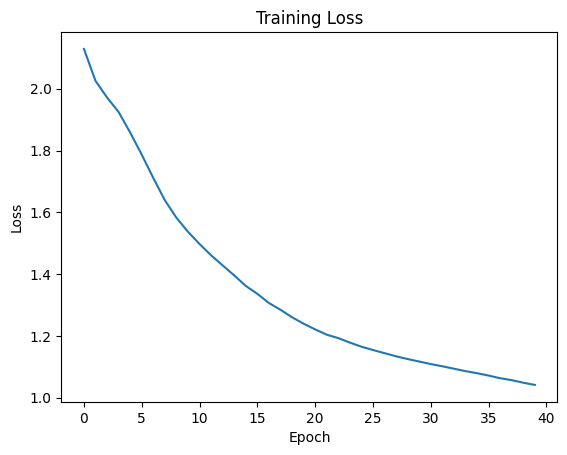

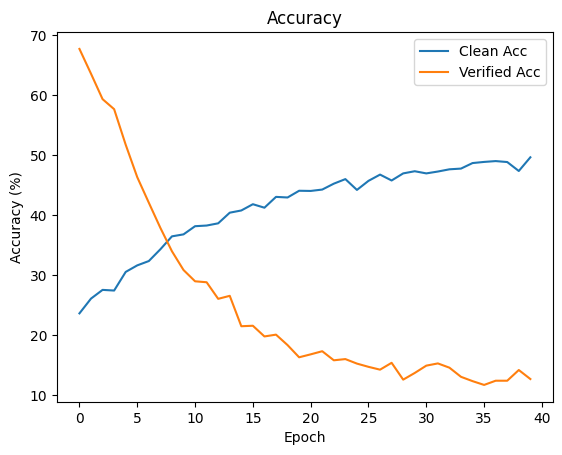

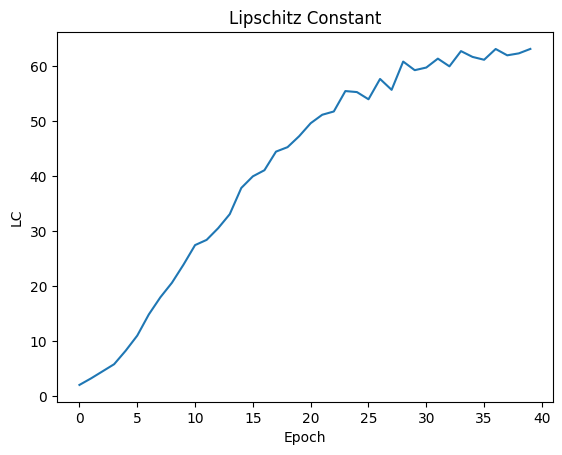

Saved lipshift_emma-1.pt


In [21]:
from tqdm import tqdm
import time, csv
import matplotlib.pyplot as plt
import torch, torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

def train():
    device = torch.device('cpu')
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset  = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    test_loader  = DataLoader(testset , batch_size=256, shuffle=False, num_workers=2)

    model = LipShiftNet(dim=128, depth=6).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-2)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100)

    # logs
    train_losses, clean_accs, verified_accs, lcs = [], [], [], []

    for epoch in range(40):
        t0 = time.time()
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/40", leave=False)

        running_loss = 0.0
        for i, (x, y) in enumerate(loop):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            lc = model.get_lc()
            loss = emma_loss(model, x, y, lc, eps=8/255)
            loss.backward()
            opt.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item(), lc=f"{lc:.2f}")

        sched.step()

        # average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # evaluation
        clean, ver, lc = evaluate(model, test_loader, device)
        clean_accs.append(clean)
        verified_accs.append(ver)
        lcs.append(lc)

        print(f'epoch {epoch:02d}  loss {avg_loss:.4f}  '
              f'clean {clean*100:5.1f}%  verified {ver*100:5.1f}%  '
              f'lc {lc:6.2f}  ({time.time()-t0:4.1f}s)')

    # save logs to CSV
    with open("lipshift_emma_metrics.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "TrainLoss", "CleanAcc", "VerifiedAcc", "LipschitzConst"])
        for i in range(len(train_losses)):
            writer.writerow([
                i+1,
                train_losses[i],
                clean_accs[i]*100,
                verified_accs[i]*100,
                lcs[i]
            ])

    # plots
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.plot([c*100 for c in clean_accs], label="Clean Acc")
    plt.plot([v*100 for v in verified_accs], label="Verified Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

    plt.plot(lcs)
    plt.title("Lipschitz Constant")
    plt.xlabel("Epoch")
    plt.ylabel("LC")
    plt.show()

    # save final model
    torch.save(model.state_dict(), 'lipshift_emma-1.pt')
    print('Saved lipshift_emma-1.pt')

    return model, (train_losses, clean_accs, verified_accs, lcs)


if __name__ == '__main__':
    train()
